First, let's read the pre-processed data

In [1]:
%matplotlib inline
#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
import matplotlib.pyplot as plt; plt.rc('figure', dpi=100)
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns

data_path = '../../data/TfT/MouseData_processed_merged/'
file_name = 'all_mouse_data.csv'
data = pd.read_csv(os.path.join(data_path, file_name)).set_index(['participant', 'trial_no'])

It's nice to have timestamp with respect to trial start. Also, we convert time from milliseconds to seconds (e.g., 5 to 0.005). Just in case, we keep original timestamps in `t_original`. 

In [2]:
data.loc[:, 't_original'] = data.t
data.loc[:, 't'] = data.t.groupby(['participant', 'trial_no']).transform(lambda t: (t-t.min())/1000.0)

Let's take a look at a random trajectory

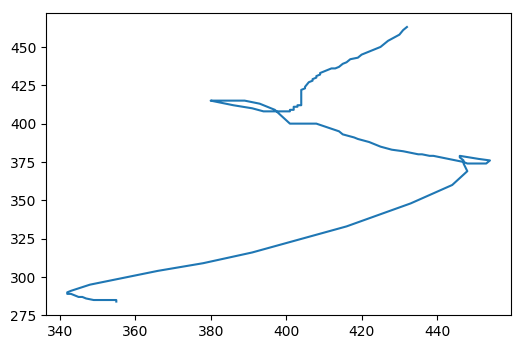

In [3]:
trial = random.choice(data.index)
trajectory = data.loc[trial]

plt.plot(trajectory.x, trajectory.y);

Next, let's plot a bunch of trajectories to get an idea of what's happening in terms of screen coordinates

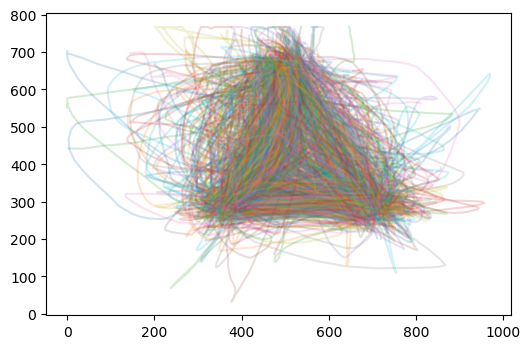

In [4]:
for trial in data.index.unique()[:1000]:
    trajectory = data.loc[trial]
    plt.plot(trajectory.x, trajectory.y, alpha=0.2)

The screen dimensions were 1024x768 pixels. Given that participants started their response from the bottom center of the screen, it seems that the origin (0,0) is actually in the top left corner (unlike the plot above). Let's transform the coordinate system so that the trajectories, when plotted, go from bottom to top.  Also, we center the x-coordinates of the trajectories around zero.

In [5]:
data['x'] = data['x'] - 1024/2
data['y'] = 768 - data['y']

Just checking that this helped:

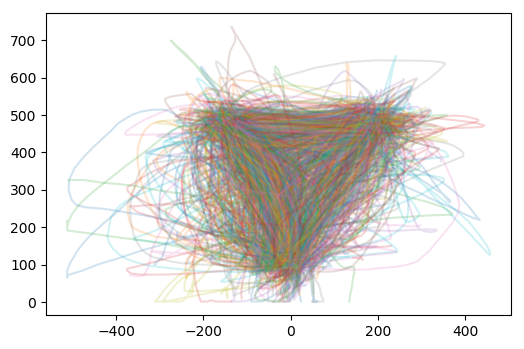

In [6]:
for trial in data.index.unique()[:1000]:
    trajectory = data.loc[trial]
    plt.plot(trajectory.x, trajectory.y, alpha=0.2)

Now let's prepare some mouse-tracking measures, starting with maximum deviation (`max_d`) and time when deviation reached maximum (relative to trajectory duration, `rel_t_max_d`). We'll also keep index of max-d (`idx_max_d`) just in case.

In [7]:
def get_maxd(traj):
    alpha = np.arctan((traj.y.iloc[-1]-traj.y.iloc[0])/ \
                        (traj.x.iloc[-1]-traj.x.iloc[0]))
    d = (traj.x.values-traj.x.values[0])*np.sin(-alpha) + \
        (traj.y.values-traj.y.values[0])*np.cos(-alpha)
    if abs(d.min())>abs(d.max()):
        max_d = d.min()
        idx_max_d = d.argmin()
    else:
        max_d = d.max()
        idx_max_d = d.argmax()
        
    return pd.Series({'max_d': max_d, 'idx_max_d': idx_max_d, 'rel_t_max_d': idx_max_d/len(traj)})

mt_measures = data.groupby(['participant', 'trial_no']).apply(get_maxd)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


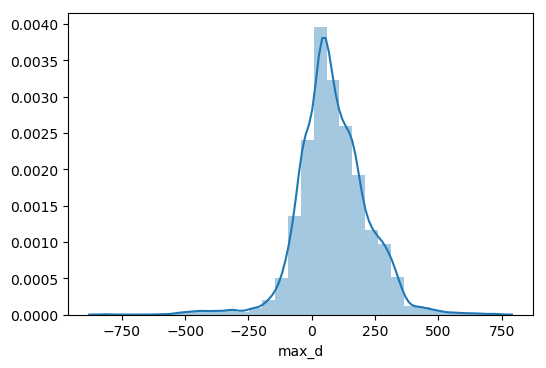

In [8]:
sns.distplot(mt_measures.max_d, bins=30);

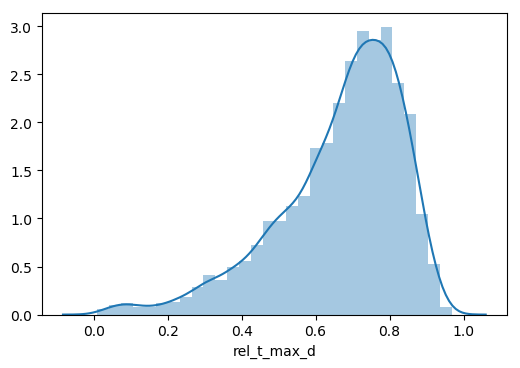

In [9]:
sns.distplot(mt_measures.rel_t_max_d, bins=30);

NB: I opted for max-d in favor of area under curve (AUC) because it works better for trajectories with loops, but generally the two are highly correlated.

To analyze trials involving changes-of-mind (CoM), it's useful to have `midline_d` metric, which measures how far the trajectory reached towards the non-chosen option. 

In [10]:
def get_midline_d(traj):
    x = traj.x.values
    midline_d, idx_midline_d, rel_time_midline_d, midline_d_y = 0, 0 , 0, 0
    is_final_point_positive = (x[-1]>0)
    if ((x[-1]>0) & (x<0).any()):
        midline_d = x.min()
        idx_midline_d = (x == midline_d).nonzero()[0][-1]
        midline_d_y = traj.y.values[idx_midline_d]
    elif ((x[-1]<0) & (x>0).any()):
        midline_d = x.max()
        idx_midline_d = (x == midline_d).nonzero()[0][-1]
        midline_d_y = traj.y.values[idx_midline_d]
    return pd.Series({'midline_d': abs(midline_d), 
                      'idx_midline_d': idx_midline_d,
                      'rel_t_midline_d': idx_midline_d/len(traj),
                      'midline_d_y': midline_d_y})

mt_measures = mt_measures.join(data.groupby(['participant', 'trial_no']).apply(get_midline_d))

If a trajectory does not have a CoM, its `midline_d` should theoretically be equal to zero. However, because of the random location of the click within the start button (and some other random factors), not all trajectories with `midline_d>0` are actually changes-of-mind. So we introduce an (arbitrary) threshold and assign CoM label to all trajectories whose midline_d exceeds this threshold.

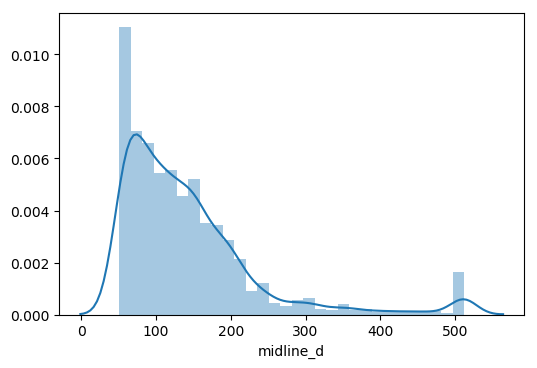

In [11]:
midline_d_threshold = 50
mt_measures['is_com'] = (mt_measures.midline_d > midline_d_threshold)
sns.distplot(mt_measures[mt_measures.is_com].midline_d, bins=30);

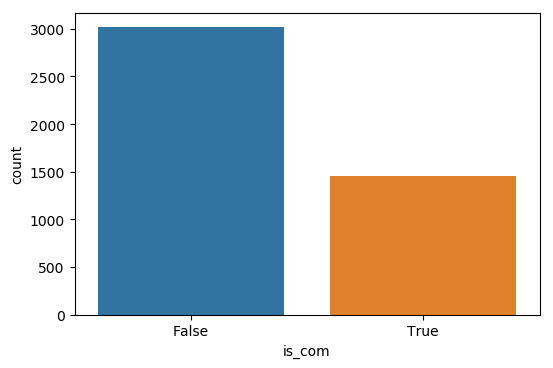

In [12]:
sns.countplot(mt_measures.is_com);

To calculate x-flips (number of changes in the sign of x-velocity), we need to numerically compute time derivatives of the mouse coordinate. Mouse velocities also might come handy in future, so we'll keep it along with the data. 

In [13]:
def differentiate(t, x):
    # To be able to reasonably calculate derivatives at the end-points of the trajectories,
    # I append three extra points before and after the actual trajectory, so we get N+6
    # points instead of N       
    x = np.append(x[0]*np.ones(3), np.append(x, x[-1]*np.ones(3)))

    # Time vector is also artificially extended by equally spaced points
    # Use median timestep to add dummy points to the time vector
    timestep = np.median(np.diff(t))
    t = np.append(t[0]-np.arange(1,4)*timestep, np.append(t, t[-1]+np.arange(1,4)*timestep))

    # smooth noise-robust differentiators, see: 
    # http://www.holoborodko.com/pavel/numerical-methods/ \
    # numerical-derivative/smooth-low-noise-differentiators/#noiserobust_2
    v = (1*(x[6:]-x[:-6])/((t[6:]-t[:-6])/6) + 
         4*(x[5:-1] - x[1:-5])/((t[5:-1]-t[1:-5])/4) + 
         5*(x[4:-2] - x[2:-4])/((t[4:-2]-t[2:-4])/2))/32

    return v

def get_derivatives(data):
    names = {'x': 'vx', 'y': 'vy'}      

    for col_name, der_name in names.items():
        data[der_name] = np.concatenate(
                [differentiate(traj['t'].values, traj[col_name].values) 
                        for traj_id, traj in data.groupby(level=['participant', 'trial_no'], group_keys=False)]
                )
    return data

data = get_derivatives(data)

In [14]:
mt_measures['x_flips'] = data.groupby(level=['participant', 'trial_no']).\
                        apply(lambda traj: (abs(np.diff(np.sign(traj.vx.values)[np.nonzero(np.sign(traj.vx))]))>1).sum())  

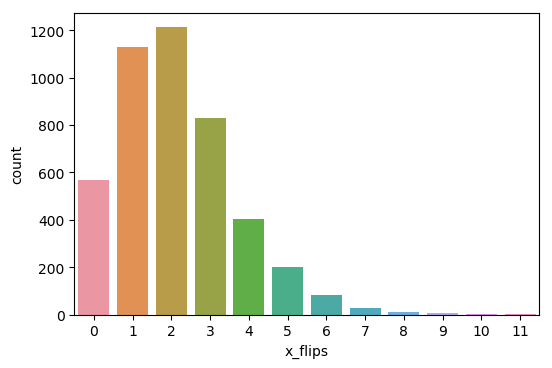

In [15]:
sns.countplot(mt_measures.x_flips);

Finally, we save the data with derivatives to a new file, and also save to a separate file all the measures we derived.

In [16]:
measures_data_path = '../../data/TfT/MouseData_with_measures/'
data.to_csv(os.path.join(measures_data_path, 'all_mouse_data.csv'), index=True)
mt_measures.to_csv(os.path.join(measures_data_path, 'mt_measures.csv'), index=True)

# NB

These measures are quite rough, mostly because there are trajectories which don't conform to the expected pattern (e.g., trajectories sometimes start in unexpected places in participants 11, 12, 14). However, for the vast majority of the trajectories, these measures should work.

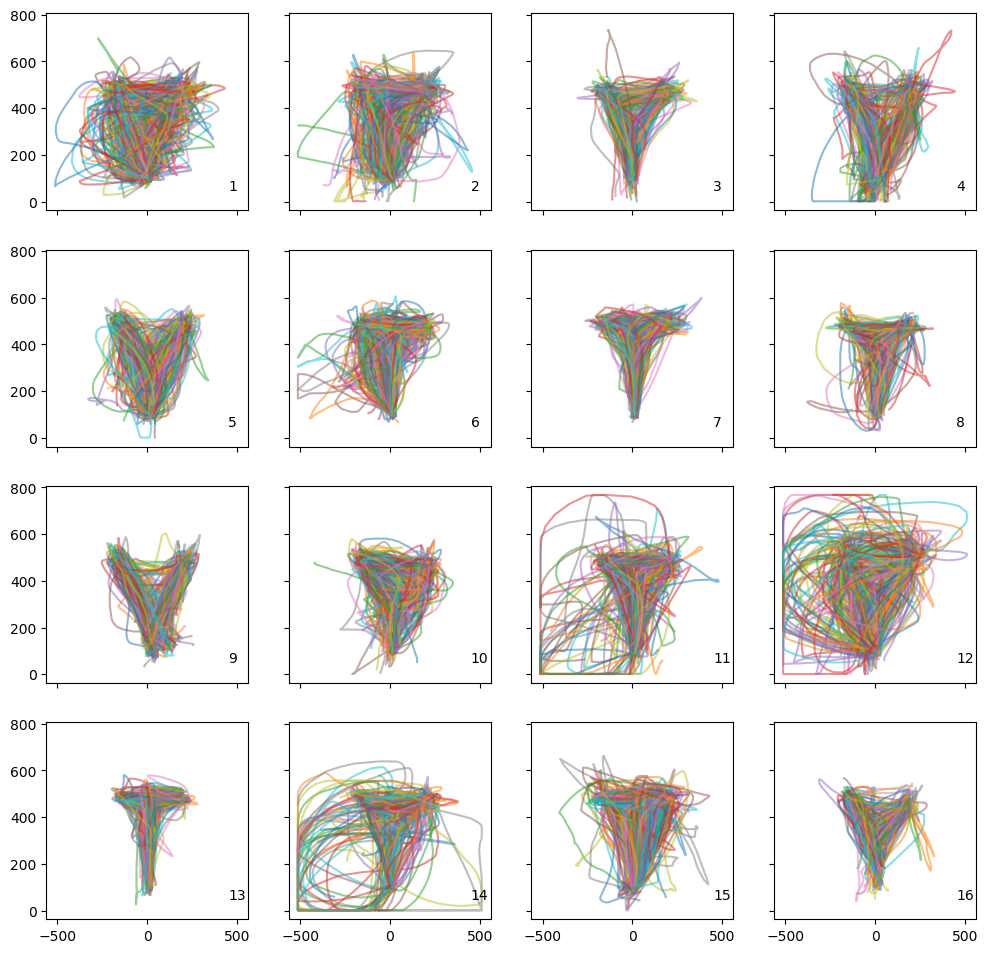

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(12,12), sharex=True, sharey=True)
for participant in data.index.get_level_values('participant').unique():
    ax = axes[int(np.floor((participant-1)/4)), participant % 4-1]
    for trial in range(1,281):
        traj = data.loc[(participant, trial)]
        ax.plot(traj.x, traj.y, alpha=0.5);
    ax.text(x=450, y=50, s=participant)

Here are some of the trials with weird trajectories: marked as changes-of-mind, but without any x-flips

In [18]:
mt_measures[(mt_measures.is_com) & (mt_measures.x_flips==0)]

idx_max_d       max_d  rel_t_max_d  idx_midline_d  \
participant trial_no                                                      
1           23            151.0 -159.341852     0.470405           99.0   
2           62            241.0   11.417715     0.676966          227.0   
3           218           118.0   31.114278     0.452107           33.0   
4           252           181.0  -54.612787     0.581994          106.0   
5           3             498.0   58.133539     0.804523          439.0   
7           32            152.0  -27.329870     0.435530            0.0   
8           155           298.0   41.038820     0.844193          256.0   
            232           191.0  -22.758044     0.656357          175.0   
            257           368.0  -13.631730     0.686567           11.0   
9           53            214.0  -21.190096     0.679365           94.0   
            66            185.0   10.984165     0.764463            0.0   
            94            293.0  -71.308929     0.544610            2.0   
            103           240.0  -11.546944     0.827586           21.0   
            106           174.0 -229.934780     0.440506           80.0   
            208           218.0 -132.857661     0.714754           24.0   
            255           116.0  -33.260462     0.386667           62.0   
10          171           329.0   19.436920     0.721491           19.0   
            235            73.0  -34.927378     0.336406            1.0   
            259           108.0   46.351653     0.521739           30.0   
11          4             228.0   46.219729     0.742671          215.0   
            27            157.0   23.095872     0.509740          130.0   
            29            213.0   19.904733     0.612069          203.0   
            35            249.0  250.434447     0.488235          248.0   
            233           142.0   96.409447     0.609442           53.0   
12          2             366.0  -40.710749     0.764092          275.0   
            51            288.0  -23.981876     0.721805          218.0   
            55            204.0  -17.096717     0.752768           92.0   
            252           385.0  -17.523278     0.881007          353.0   
14          58            339.0 -111.458986     0.710692            1.0   
            85            456.0  -33.688587     0.865275          422.0   
            115           232.0  -37.788187     0.743590            1.0   
            152           381.0  -98.383371     0.771255            1.0   
            173            35.0  224.807248     0.077434           21.0   
            176            33.0    9.672361     0.084833            2.0   
            177           397.0  -11.155626     0.861171          262.0   
            181           577.0   12.060352     0.900156          230.0   
            192            36.0  406.546566     0.101124           29.0   
            247            50.0    6.635588     0.120192            1.0   
16          193           165.0    7.517185     0.760369          132.0   

                      midline_d  midline_d_y  rel_t_midline_d  is_com  x_flips  
participant trial_no                                                            
1           23            174.0        173.0         0.308411    True        0  
2           62            101.0        188.0         0.637640    True        0  
3           218            64.0        339.0         0.126437    True        0  
4           252           111.0        386.0         0.340836    True        0  
5           3             130.0         77.0         0.709208    True        0  
7           32             53.0        525.0         0.000000    True        0  
8           155           135.0        227.0         0.725212    True        0  
            232           108.0        449.0         0.601375    True        0  
            257            58.0        452.0         0.020522    True        0  
9           53             51.0        164.0         0.

And this is an example of such trajectory. We have to decide what to do with these, and if we want to exclude them, what should the exclusion criteria be.

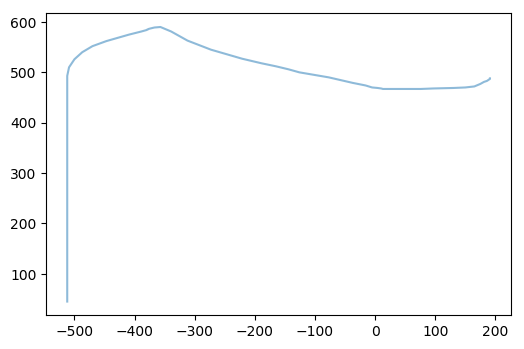

In [19]:
traj = data.loc[(14, 192)]
plt.plot(traj.x, traj.y, alpha=0.5);